In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1,
    palette="deep"
)

# Paths
HERE = Path(".").absolute()
ROOT = HERE.parent.parent
FIGS = ROOT/"figs"
FIGS.mkdir(exist_ok=True)

# Main parameters
COLORS = np.array(["#c76674", "#9a9945", "#8961b3"])
GRAY = "#efefef"
FSIZE = 16
FWEIGHT = "bold"
FONTS = dict(fontsize=FSIZE, fontweight=FWEIGHT)

LABELS = ["Real", "ER", "Configuration"]
METHODS = ["balance", "k_balance", "node_balance", "pairwise_cohesion"]

with open(HERE/"accuracy.pkl", "rb") as fh:
    data = pickle.load(fh)


# Accuracy of approximations in Multiscale Semiwalk Balance approach

## Accuracy and the truncation order (`kmax`)

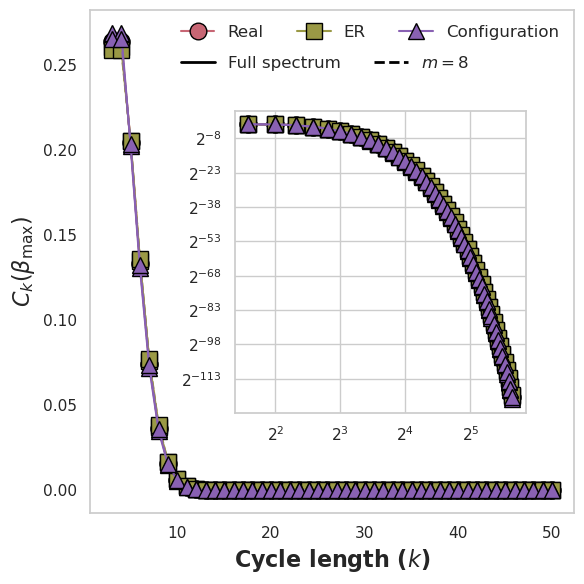

In [2]:
fig, ax = plt.subplots(figsize=(6, 6))
axin = ax.inset_axes([.3, .2, .6, .6])

cdata = data["cdata"]
cdata["label"] = pd.Categorical(cdata["label"], LABELS)

for opts in plt.cycler(
    gdf=cdata.groupby("label"),
    color=COLORS,
    marker=["o", "s", "^"]
):
    label, gdf = opts.pop("gdf")
    C0 = gdf["contrib"]
    C1 = gdf["contrib8"]
    kvec = gdf["K"]
    kwds = { "markeredgecolor": "black", "markersize": 12, **opts }
    ax.plot(kvec, C0, **kwds, ls="-", label=label)
    ax.plot(kvec, C1, **kwds, ls="--")

    axin.plot(kvec, C0, **kwds, ls="-")
    axin.plot(kvec, C1, **kwds, ls="--")
    axin.set_yscale("log", base=2)
    axin.set_xscale("log", base=2)

ax.grid(False)
ax.set_xlabel(r"Cycle length ($k$)", **FONTS)
ax.set_ylabel(r"$C_k(\beta_{\max})$", **FONTS)
ax.legend(ncol=3, frameon=False, fontsize=12)

handles = [
    mpl.lines.Line2D(
        [0], [0], color="black", lw=2, ls=ls,
        label=label,
    ) for label, ls in zip(["Full spectrum", r"$m = 8$"], ["-", "--"])
]
legend1 = fig.legend(
    handles=handles, loc="upper right", ncol=len(handles),
    frameon=False, bbox_to_anchor=(.82, .92),
    fontsize=12
)

fig.tight_layout()
fig.savefig(FIGS/"perf-contrib.pdf", bbox_inches="tight")


## Accuracy and number of eigenpairs ($m$)

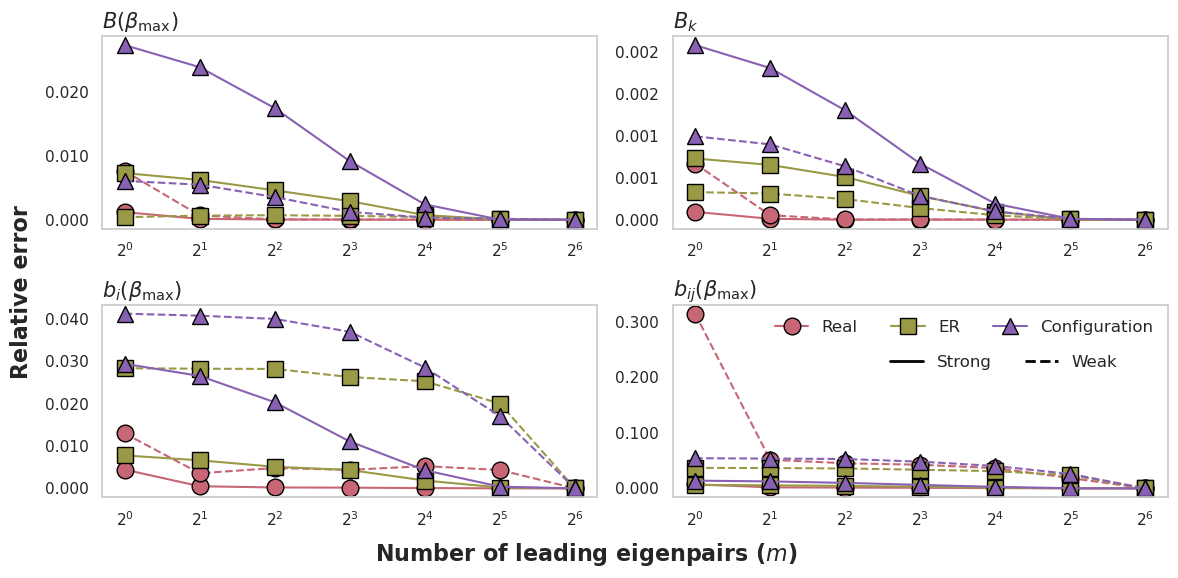

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
handles = [
    mpl.lines.Line2D(
        [0], [0], color="black", lw=2, ls=ls,
        label=label,
    ) for label, ls in zip(["Strong", r"Weak"], ["-", "--"])
]

adata = data["adata"]
adata["label"] = pd.Categorical(adata["label"], LABELS)
adata["method"] = pd.Categorical(adata["method"], METHODS)

for ax, gdf in zip(axes.flat, adata.groupby(["method", "key"])):
    group, gdf = gdf
    method, title = group
    if "_i" in title:
        title = title.replace("B_i", "b_{i}")
    elif "_{ij}" in title:
        title = title.replace("B_{ij}", "b_{ij}")
    if (pat := "G, ") in title:
        title = title.replace(pat, "")
    elif (pat := "G") in title:
        title = title.replace(pat, "")
    if (pat := "()") in title:
        title = title.replace(pat, "")
    for opts in plt.cycler(
        df=gdf.groupby("label"),
        color=COLORS,
        marker=["o", "s", "^"]
    ):
        label, df = opts.pop("df")
        m = df["m"]
        err_s = df["err_s"]
        err_w = df["err_w"]
        kwds = { "markeredgecolor": "black", "markersize": 12, **opts }

        ax.plot(m, err_s, **kwds, ls="-", label=label)
        ax.plot(m, err_w, **kwds, ls="--")
        ax.set_xscale("log", base=2)
        ax.set_title(title, x=0, fontsize=15, horizontalalignment="left")
        ax.grid(False)
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.3f"))

ax = axes[1, 1]
ax.legend(loc="upper right", ncol=3, frameon=False, fontsize=12)
fig.legend(
    handles=handles, loc="upper right", ncol=len(handles),
    frameon=False, bbox_to_anchor=(.955, .42), fontsize=12,
    facecolor=GRAY
)
fig.supxlabel(r"Number of leading eigenpairs ($m$)", **FONTS, y=.04)
fig.supylabel("Relative error", **FONTS)
fig.tight_layout()
fig.savefig(FIGS/"perf-accuracy.pdf", bbox_inches="tight")
